In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform, util, color
from pillclassification.feature_extraction import feature_extraction
import xml.etree.ElementTree as ET
import pandas as pd

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [144]:
# Load image

images_dir = Path('utils/Dataset/merge')
filenames = [x for x in images_dir.iterdir() if x.suffix != '.xml']
tree = ET.parse(images_dir / 'images.xml')
se = list(tree.getroot())[0]

X = []
Y = []

shapes = {
    'OVAL': 0,
    'ROUND': 1,
    'CAPSULE': 2,
    'TRIANGLE': 3,
    'PENTAGON': 5
}
header_X = ['filename', 'hu','color1', 'color2']
header_Y = ['filename', 'shape', 'color1', 'color2']

for idx, filename in enumerate(filenames):
    image_orig = io.imread(filename)

    if image_orig.shape[-1] == 4:
        image_orig = image_orig[:,:,:3]

    crop_scale = 0.8

    def crop_center(img):
        y,x,d = img.shape
        cropx = int(x * crop_scale)
        cropy = int(y * crop_scale)
        startx = int(x/2-(cropx/2))
        starty = int(y/2-(cropy/2)) - 100 
        return img[starty:starty+cropy,startx:startx+cropx,:]

    height = 600
    image = crop_center(image_orig)
    image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
    image = util.img_as_float(image)
    # plt.figure(figsize=(10,10))
    # plt.imshow(image)
    # plt.show()

    hu, color = feature_extraction(image)
    
    image_xml = None
    for e in list(se):
        xml_el = e.find('File').find('Name')
        if xml_el is not None and xml_el.text == filename.name: 
            image_xml = e
            break
            
    if image_xml is None:
        print('What')
        break
    
    true_colors = list(map(lambda x : x.text, image_xml.findall('Color')))
    if len(true_colors) == 1:
        true_colors.append(None)
    true_shape = image_xml.find('Shape').text.split()[0]
    
    print('\r{:3}/{}: {} {}'.format(idx + 1, max_files, true_color, true_shape), end='')
    
    X.append([filename, hu, color, color])
    Y.append([filename, shapes[true_shape], true_color, true_color])
    
X_df = pd.DataFrame(X, columns=header_X)
Y_df = pd.DataFrame(Y, columns=header_Y)

print(X_df)
print(Y_df)

ValueError: not enough values to unpack (expected 2, got 1)

In [2]:
images_dir = Path('utils/Dataset/merge')
filenames = [x for x in images_dir.iterdir() if x.suffix != '.xml']
tree = ET.parse(images_dir / 'images.xml')
se = list(tree.getroot())[0]

from joblib import Parallel, delayed

def joblib_loop():
    Parallel(n_jobs=10)(delayed(task)(i, filename) for i, filename in enumerate(filenames[:10]))

X = []
Y = []

def task(i, filename):
    image_orig = io.imread(filename)

    if image_orig.shape[-1] == 4:
        image_orig = image_orig[:,:,:3]

    crop_scale = 0.8

    def crop_center(img):
        y,x,d = img.shape
        cropx = int(x * crop_scale)
        cropy = int(y * crop_scale)
        startx = int(x/2-(cropx/2))
        starty = int(y/2-(cropy/2)) - 100 
        return img[starty:starty+cropy,startx:startx+cropx,:]

    height = 600
    image = crop_center(image_orig)
    image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
    image = util.img_as_float(image)
    # plt.figure(figsize=(10,10))
    # plt.imshow(image)
    # plt.show()

    hu, color = feature_extraction(image)
    
    # print('\r{:3}/{}: {} {}'.format(idx + 1, max_files, true_color, true_shape), end='')
    
    X.append([filename, hu, color])
    Y.append([filename])
    
    
def task1():
    for idx, filename in enumerate(filenames[:10]):
        image_orig = io.imread(filename)

        if image_orig.shape[-1] == 4:
            image_orig = image_orig[:,:,:3]

        crop_scale = 0.8

        def crop_center(img):
            y,x,d = img.shape
            cropx = int(x * crop_scale)
            cropy = int(y * crop_scale)
            startx = int(x/2-(cropx/2))
            starty = int(y/2-(cropy/2)) - 100 
            return img[starty:starty+cropy,startx:startx+cropx,:]

        height = 600
        image = crop_center(image_orig)
        image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
        image = util.img_as_float(image)
        # plt.figure(figsize=(10,10))
        # plt.imshow(image)
        # plt.show()

        hu, color = feature_extraction(image)

        # print('\r{:3}/{}: {} {}'.format(idx + 1, max_files, true_color, true_shape), end='')

        X.append([filename, hu, color])
        Y.append([filename])
    
%timeit joblib_loop()

# %timeit task1()

6.13 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
tree = ET.parse(images_dir / 'images.xml')
se = list(tree.getroot())[0]
file = se.findall('.//File[Name="{}"]'.format(filename.name))[0]
print(file.get('Name'))

None
['ciao', 'c']


In [103]:
import pandas as pd
from sklearn import svm

clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(X, Y)

SVC(kernel='linear')

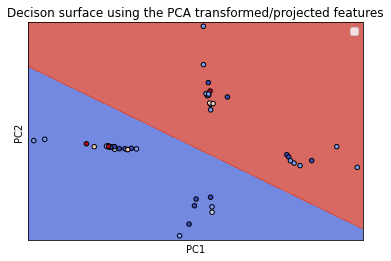

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = svm.SVC(kernel='linear')
clf = model.fit(Xreduced, Y)

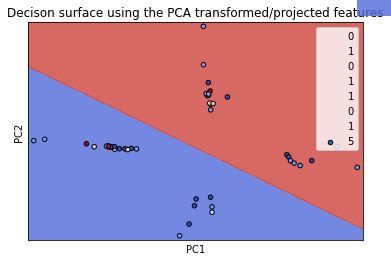

In [120]:
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend(Y)
plt.show()

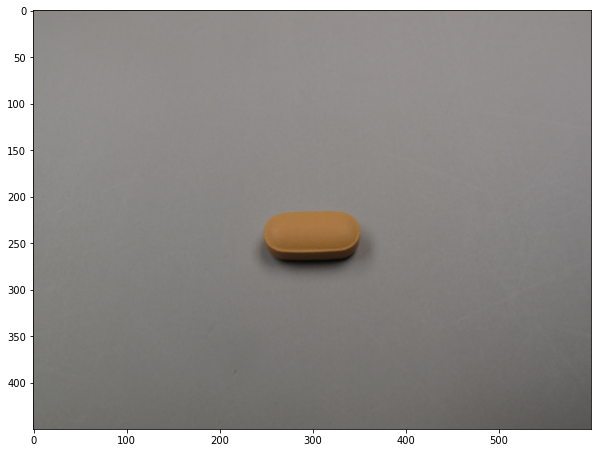

[ 0.66473652  1.67820054  6.15247531  7.62988082 14.73558885  8.64193355
 14.62219678] [0.61535223 0.4382689  0.24756552]


In [122]:
image_orig = io.imread(filenames[410])

if image_orig.shape[-1] == 4:
    image_orig = image_orig[:,:,:3]

crop_scale = 0.8

def crop_center(img):
    y,x,d = img.shape
    cropx = int(x * crop_scale)
    cropy = int(y * crop_scale)
    startx = int(x/2-(cropx/2))
    starty = int(y/2-(cropy/2)) - 100 
    return img[starty:starty+cropy,startx:startx+cropx,:]

height = 600
image = crop_center(image_orig)
image = transform.resize(image, (int(image.shape[0] * (height / image.shape[1])), height), anti_aliasing=True)
image = util.img_as_float(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

hu, color = feature_extraction(image)
print(hu, color)

In [137]:
clf.predict(np.reshape(hu, (-1,1)))

ValueError: X.shape[1] = 1 should be equal to 2, the number of features at training time